# EEST Flowcharts

In [1]:
from pathlib import Path

from diagrams import Cluster, Diagram, Edge
from diagrams.custom import Custom
from diagrams.programming.language import Bash, Go, Python
from scour import scour


def embed_svg_images(filename):
    """
    Workaround for embedding images in SVG files, see:
    https://github.com/mingrammer/diagrams/issues/8#issuecomment-633121034
    """
    with open(filename, "r") as f:
        in_string = f.read()
        out_string = scour.scourString(in_string)
    with open(filename, "w") as f:
        f.write(out_string)

output_formats = ["svg", "png"]
output_dir = Path("./")

add_captions = False
def add_caption(caption: str) -> str:
    if add_captions:
        return caption
    return ""

In [2]:
output_path_no_ext = output_dir / "fill"

with Diagram(
    add_caption("Generating tests with fill"), show=False, outformat=output_formats, filename=output_path_no_ext
) as fill_flowchart:

    fixtures = Custom("fixtures/**/*.json", "./img/json.png")

    with Cluster("t8n tool"):
        t8n_python = Python("$ eels-daemon")

    with Cluster("ethereum/execution-spec-tests"):
        test_source = Python("./tests/**/*.py")
        fill = Bash("$ fill")

    test_source >> fill >> fixtures
    t8n_python >> fill

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))

In [3]:
output_path_no_ext = output_dir / "consume_direct"
with Diagram(
    add_caption("Executing Tests via a Client's Direct Interface"),
    show=False,
    outformat=output_formats,
    filename=output_dir / "consume_direct"
) as consume_direct:

    fixtures = Custom("{blockchain_tests,\nstate_tests}/**/*.json", "./img/json.png")
    with Cluster("Test Execution"):
        with Cluster("Client Test Interface"):
            client = Custom("$ statetest\n$ blocktest\n$ eoftest", "./img/clients.png")
        with Cluster("ethereum/execution-spec-tests"):
            consume = Bash("$ consume direct")
    test_report = Custom("test_report.html", "./img/html.png")

    consume << Edge(label="client interface") >> client
    fixtures >> consume >> test_report

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))


In [4]:
output_path_no_ext = output_dir / "consume_rlp"

with Diagram(
    add_caption("Executing Tests by loading RLP-encoded Blocks upon startup"),
    show=False,
    outformat=output_formats,
    filename=output_path_no_ext
) as consume_rlp:

    fixtures = Custom("blockchain_tests/**/*.json", "./img/json.png")
    with Cluster("Test Execution"):
        with Cluster("Hive Test Environment (dockerized)"):
            with Cluster("ethereum/execution-spec-tests"):
                consume = Python("consume rlp")
            # with Cluster("Hive Orchestrator"):
            #     hiveproxy = Go("hiveproxy")
            with Cluster("Execution Client"):
                client = Custom("$ client.exe", "./img/clients.png")
    test_report = Custom("Test Report", "./img/html.png")

    consume << Edge(label="verify via RPC", style="dashed") >> client
    consume >> Edge(label="RLP-encoded blocks") >> client
    fixtures >> consume >> test_report

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))


In [5]:
output_path_no_ext = output_dir / "consume_engine"

with Diagram(
    add_caption("Executing Tests via the Engine API"),
    show=False,
    outformat=output_formats,
    filename=output_path_no_ext,
) as consume_engine:

    fixtures = Custom("blockchain_tests_engine/\n**/*.json", "./img/json.png")
    with Cluster("Test Execution"):
        with Cluster("Hive Test Environment (dockerized)"):
            with Cluster("ethereum/execution-spec-tests"):
                consume = Python("consume engine")
            # with Cluster("Hive Orchestrator"):
            #     hiveproxy = Go("hiveproxy")
            with Cluster("Execution Client"):
                client = Custom("$ client.exe", "./img/clients.png")
    test_report = Custom("Test Report", "./img/html.png")

    consume << Edge(label="Engine API", style="dashed") >> client
    fixtures >> consume >> test_report

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))


In [6]:
output_path_no_ext = output_dir / "execute_live"

with Diagram(
    add_caption("Executing Tests by sending transactions via RPC"),  ## (on a live network)",
    show=False,
    outformat=output_formats,
    filename=output_path_no_ext,
) as execute_live_flowchart:

    with Cluster("Test Execution"):
        with Cluster("ethereum/execution-spec-tests"):
            test_cases = Python("./tests/**/*.py\n(state_tests)")
            execute = Bash("$ execute")
        with Cluster("Execution Client"):
                client = Custom("$ client.exe", "./img/clients.png")
    test_report = Custom("Test Report", "./img/html.png")

    execute << Edge(label="eth_getTransactionByHash", style="dashed") << client
    execute >> Edge(label="eth_sendRawTransaction", style="dashed") >> client
    test_cases >> execute
    execute >> test_report
if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))



## Fill

Generates test fixtures from the test-cases in `./tests` using EESTs test filling framework.

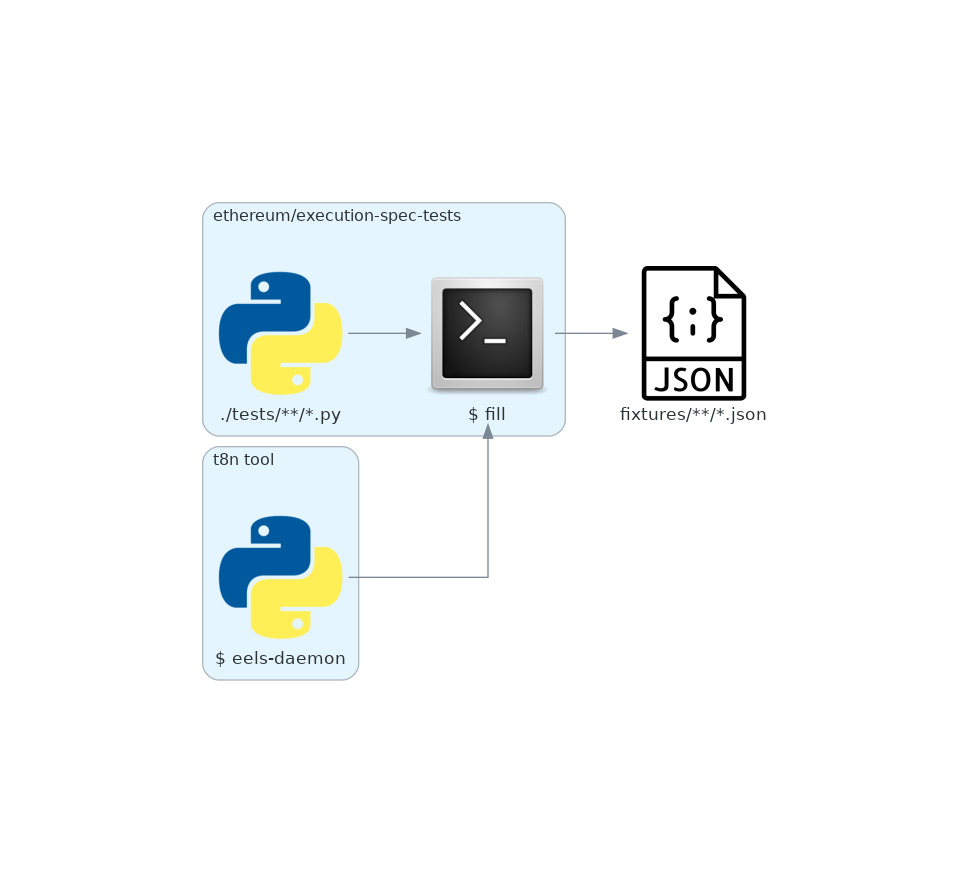

In [7]:
fill_flowchart

## Consume Direct

A thin test wrapper to execute all the specified tests discovered in the specified input JSON fixture directory via a client's native test fixture consumer interface (e.g., geth's `evm statetest` or Nethermind's `nethtest`).

- Test formats: `state_test`, `blockchain_test`, `eof_test`
- Where: Any supported platform/arch of the execution client.
- Type: EVM module test.
- Aim: Fast test execution against the EVM.


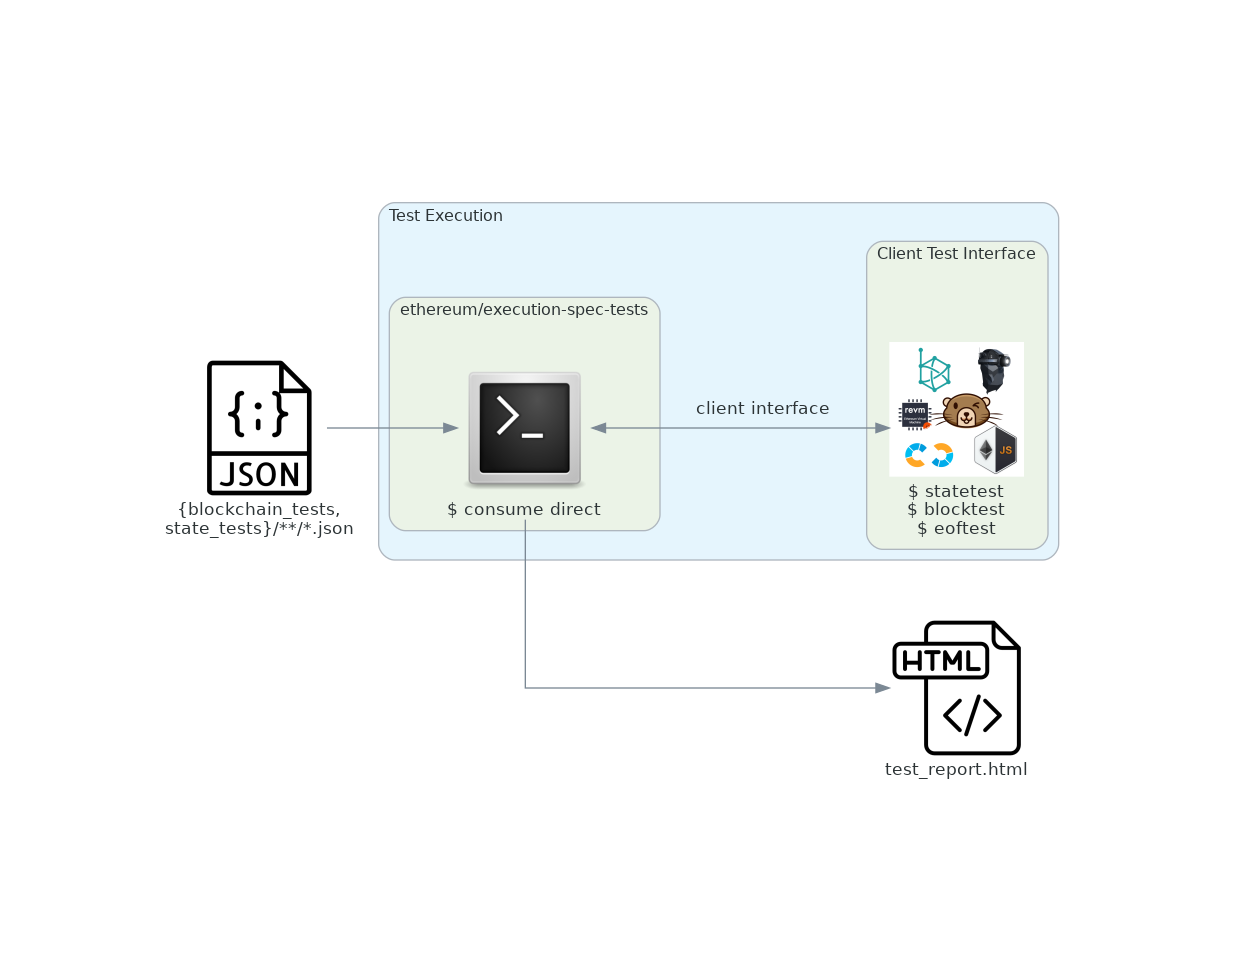

In [8]:
consume_direct


## Consume RLP

A Python re-write in EEST of the Hive Golang `ethereum/consensus` simulator. Copies a `genesis.json` and RLP-encoded blocks from blockchain fixtures to the client's Docker container for the client to load upon startup.

- Test format: `blockchain_test` JSON fixture
- Where: Hive test environment
- Type: System test of fully instantiated client
- Aim: Tests the client's sync code path.


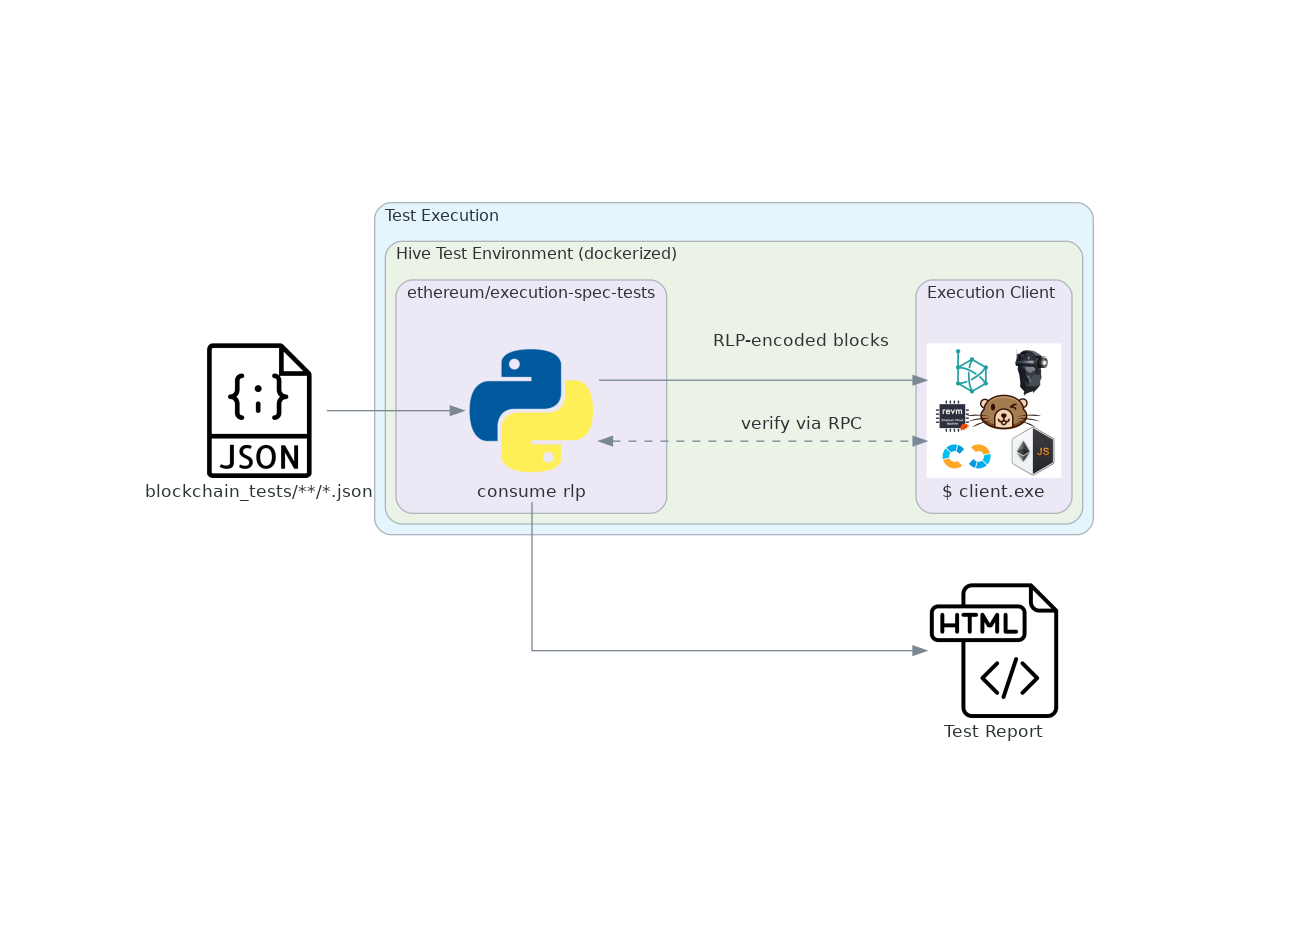

In [9]:
consume_rlp


## Consume Engine

A Python re-write in EEST of the Hive Golang `ethereum/consensus` simulator. The simulator mocks a consensus client and sends blocks from blockchain fixtures to the client via the Engine API.

- Test format: `blockchain_test_engine` JSON fixture
- Where: Hive test environment
- Type: System test of fully instantiated client
- Aim: "Interop" testing; tests client block consumption via the Engine API.


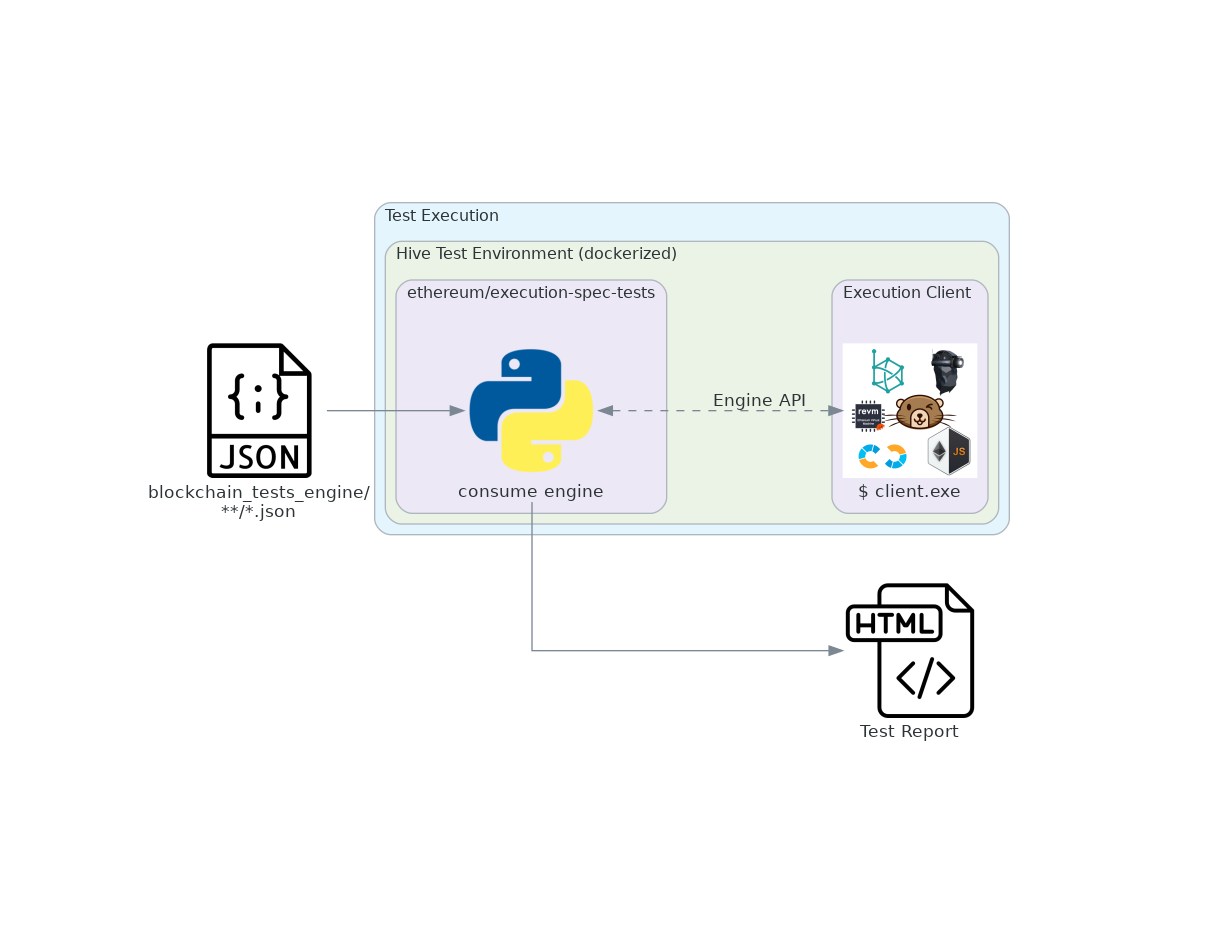

In [10]:
consume_engine


## Execute

An EEST pytest-based test tool that executes tests by sending transactions defined by state tests to a client running on a live network, e.g., devnets.

- Test format: `state_test` (direct from the Python native format; no `t8n` or JSON involved)
- Live network mode:
    - Where: Any PC with access to a execution client running on a live network.
    - Type: Production(-like) test of fully instantiated client on a live network.
- Hive mode:
    - Hive test environment.
    - Type: System test of fully instantiated client (Hive-mode).
- Aim: Test client block building and RPC endpoint


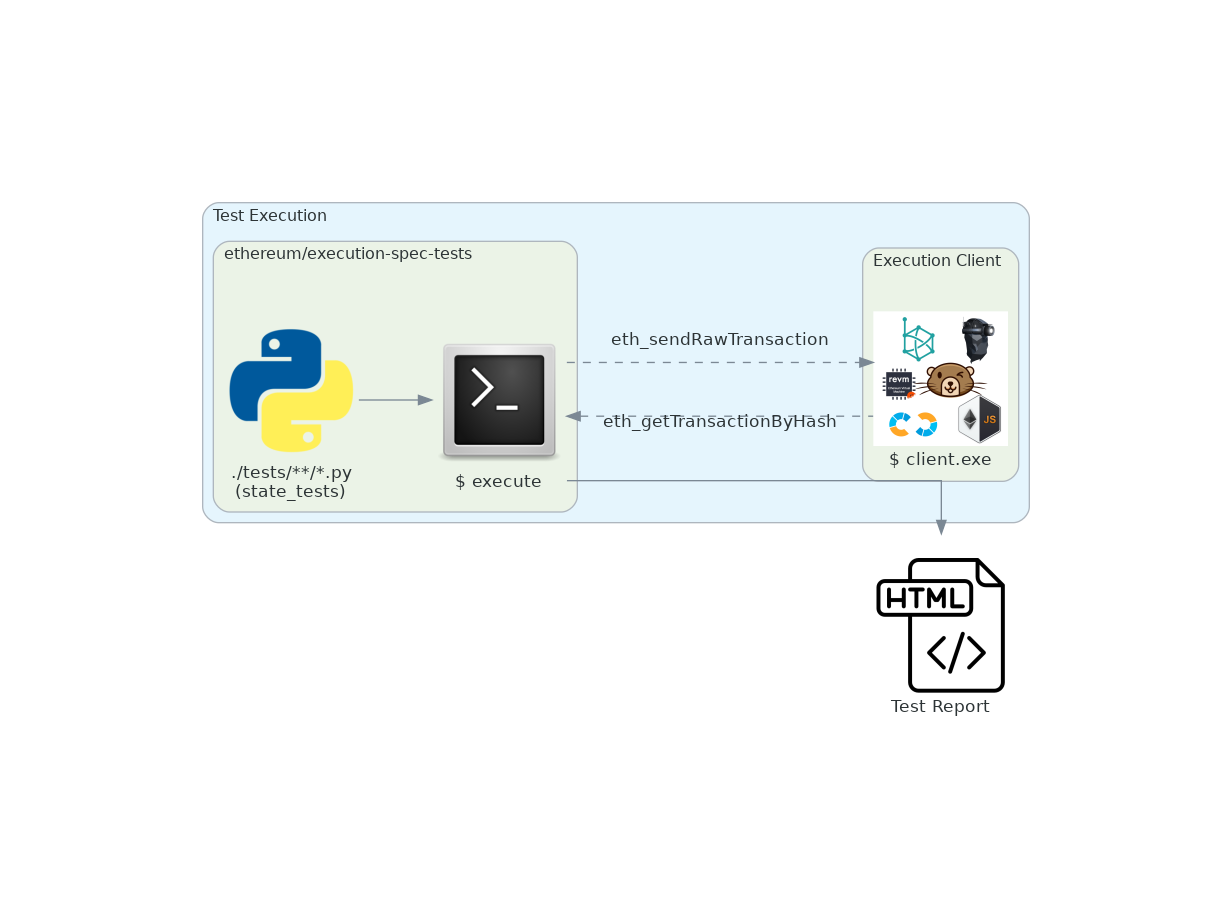

In [11]:
execute_live_flowchart

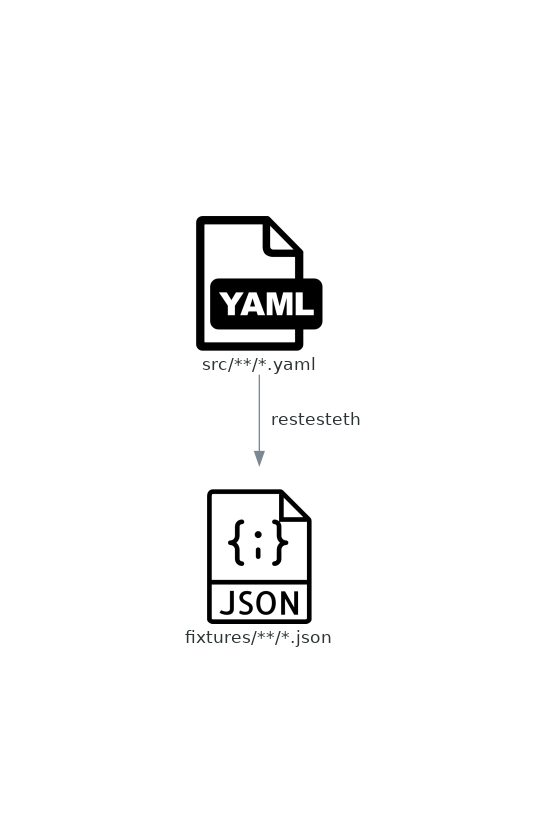

In [12]:
output_path_no_ext = output_dir / "ethereum_tests"

with Diagram(
    add_caption("Test flow with ethereum/tests"), show=False, outformat=output_formats, filename=output_path_no_ext, graph_attr={"rankdir": "TB"}
) as etests:

    yaml = Custom("src/**/*.yaml", "./img/yaml.png")

    fixtures = Custom("fixtures/**/*.json", "./img/json.png")

    yaml >> Edge(label="  restesteth") >> fixtures

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))

etests

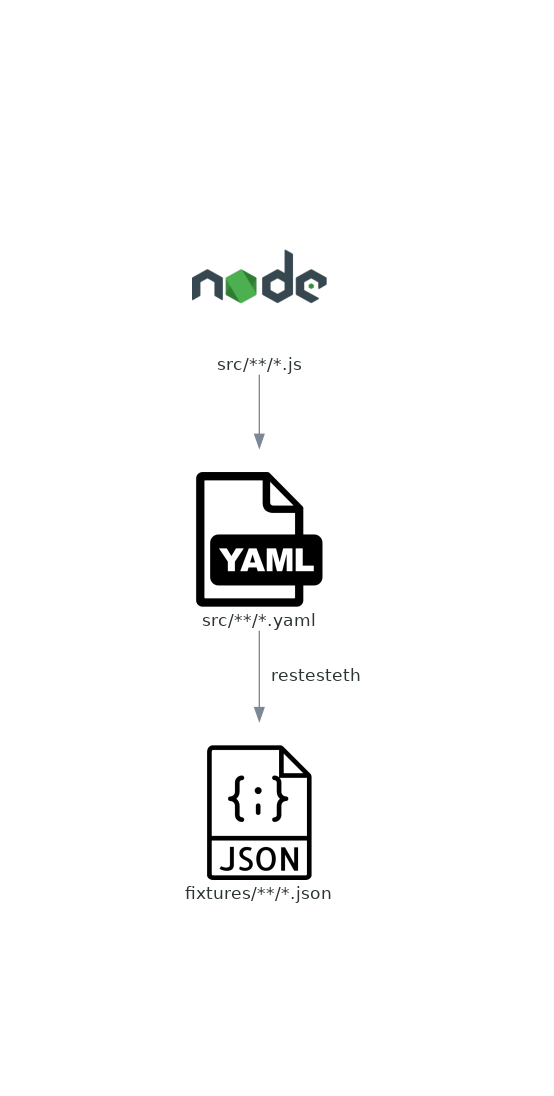

In [13]:
output_path_no_ext = output_dir / "ethereum_tests_with_js"

from diagrams.programming.language import NodeJS

with Diagram(
    add_caption("Test flow with ethereum/tests and NodeJS"), show=False, outformat=output_formats, filename=output_path_no_ext, graph_attr={"rankdir": "TB"}
) as etests_js:

    js = NodeJS("src/**/*.js")
    yaml = Custom("src/**/*.yaml", "./img/yaml.png")
    fixtures = Custom("fixtures/**/*.json", "./img/json.png")

    js >> yaml >> Edge(label="  restesteth") >> fixtures

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))

etests_js

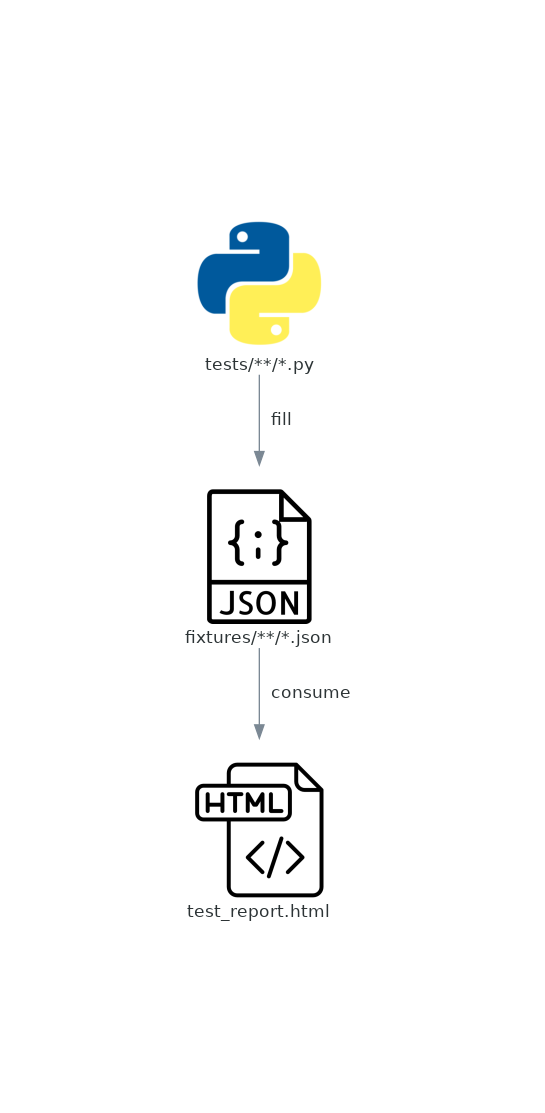

In [18]:
output_path_no_ext = output_dir / "execution_spec_tests"

with Diagram(
    add_caption("Test flow with ethereum/execution-spec-tests"), show=False, outformat=output_formats, filename=output_path_no_ext, graph_attr={"rankdir": "TB"}
) as eest:

    python = Python("tests/**/*.py")

    fixtures = Custom("fixtures/**/*.json", "./img/json.png")

    html = Custom("test_report.html", "./img/html.png")
    # with Cluster("t8n tool"):
    #     t8n_python = Python("$ eels-daemon")

    # with Cluster("ethereum/execution-spec-tests"):
    #     test_source = Python("./tests/**/*.py")
    #     fill = Bash("$ fill")

    python >> Edge(label="  fill") >> fixtures >> Edge(label="  consume") >> html
    # t8n_python >> fill

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))

eest

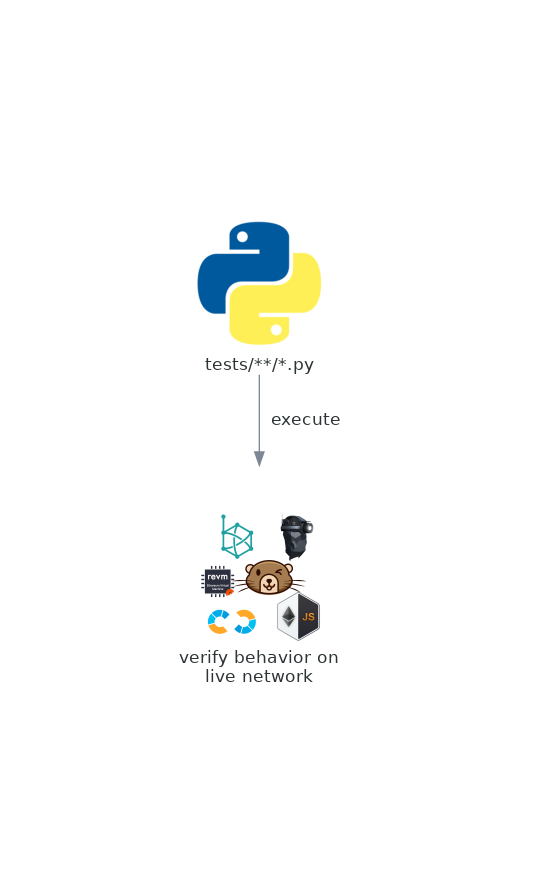

In [20]:
output_path_no_ext = output_dir / "execution_spec_tests_execute"

with Diagram(
    add_caption("Test flow with ethereum/execution-spec-tests"), show=False, outformat=output_formats, filename=output_path_no_ext, graph_attr={"rankdir": "TB"}
) as eest_execute:

    python = Python("tests/**/*.py")
    clients = Custom("verify behavior on\nlive network", "./img/clients.png")
    #fixtures = Custom("fixtures/**/*.json", "./img/json.png")

    #html = Custom("test_report.html", "./img/html.png")
    # with Cluster("t8n tool"):
    #     t8n_python = Python("$ eels-daemon")

    # with Cluster("ethereum/execution-spec-tests"):
    #     test_source = Python("./tests/**/*.py")
    #     fill = Bash("$ fill")

    python >> Edge(label="  execute") >> clients
    # t8n_python >> fill

if "svg" in output_formats:
    embed_svg_images(output_path_no_ext.with_suffix(".svg"))

eest_execute